In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras 
from keras.datasets import mnist

### MNIST Data set neural network from scratch. In this exercise I have built out the structure and associated math for a simple feed forward neural network. In this example we will explore: 
- Matrix Manipulation
- Feed Forward Network with Dense Layers
- Categorical Cross Entropy Loss
- Partial Derivatives for Backpropagation
- Updating model parameters

In [2]:
(train_features, train_targets), (test_features, test_targets) = mnist.load_data()

In [3]:
# Format test and training data as 784 pixel vectors
train_features = train_features.reshape((60000, 28 * 28))
print(train_features.shape)
test_features = test_features.reshape((10000, 28 * 28))
print(test_features.shape)

train_features = train_features.astype('float32') / 255
test_features = test_features.astype('float32') / 255

print(train_targets.shape)
print(test_targets.shape)

(60000, 784)
(10000, 784)
(60000,)
(10000,)


In [4]:
# Set up test and training data
X_train = train_features
y_train = train_targets
X_test = test_features
y_test = test_targets

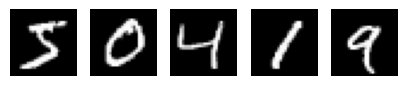

label for each of the above images:  [5 0 4 1 9]


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()
print("label for each of the above images: ", y_train[:5])

#### Create Class Variables for Neural Network Architecture such as
1. Dense Layers
2. ReLU Layers
3. Softmax activation function
4. Categorical Cross Entropy Loss

In [6]:
class DenseLayer: 

    def __init__(self, input_size, output_size):
        self.W, self.b = self.init_params(input_size, output_size)
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradB = None
        self.gradInput = None
        
    def init_params(self, input_size, output_size):
        # Initialize weights and biases
        W = np.random.randn(output_size, input_size) * 0.01
        b = np.zeros((output_size, 1))
        return W, b

    def forward(self, X):
        """
            Input: X (input data) or A[L-1] (activations from previous layer)
            Output: Z[L] (output of the layer) where Z[L] = W[L] @ A[L-1] + b[L]
        """
        self.A = X
        self.Z = self.W @ self.A + self.b
        return self.Z
    
    def backward(self, nextGradient):
        # back propogate the layers where dL/dW[L] = dL/dZ[L] @ A[L-1].T 
        self.dW = nextGradient @ self.A.T
        # db is sum of the gradients over all samples
        self.db = np.sum(nextGradient, axis=1, keepdims=True)
        # set up next grad input where dL/dA[L-1] = dL/dZ[L] @ W[L].T
        self.gradInput = self.W.T @ nextGradient
        return self.gradInput, [self.dW, self.db]
    
    def __str__(self):
        return f"W Dimension: {self.W.shape}\nb Dimension: {self.b.shape}"

In [7]:
class ReLU:
    def __init__(self):
        self.params = []
        self.gradInput = None

    def forward(self, Z):
        """
            Input: Pass non activated Z[L] to ReLU
            Output: A[L] = ReLU(Z[L]) where Z[L] = W[L] @ A[L-1] + b[L]
        """ 
        self.Z = Z
        self.A = np.maximum(Z, 0)
        return self.A
    
    def backward(self, nextGrad):
        """
            Input: nextGrad (gradient from next layer)
            Output: gradInput (gradient of the loss with respect to the input of this layer)
        """
        self.gradInput = nextGrad.copy()
        self.gradInput[self.A <= 0] = 0
        return self.gradInput, []

    def __str__(self):
        return f"ReLU Activation"

In [8]:
class CategoricalCrossEntropyLoss():
    def __init__(self):
        self.params = []
    
    def forward(self, y_true, y_pred):
        """
            Input: y_true (actual labels) and y_pred (predicted labels)
            Output: Loss value
        """
        self.y_true = y_true
        self.y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15) 
        
        # shape is 10 x m thus sum down columns with axis = 0 
        self.loss = -np.mean(np.sum(self.y_true * np.log(self.y_pred), axis = 0))
        return self.loss
    
    def backward(self, y_true, y_pred):
        """
            Input: y_true (actual labels) and y_pred (predicted labels)
            Output: Gradient of the loss with respect to the predicted labels
        """
        grad = y_pred.copy()         # shape: (10, 60000)
        grad -= y_true               # element-wise subtraction
        grad /= y_true.shape[1]      # divide by 60000 (the number of samples)
        return grad
    
    def __str__(self):
        return f"Categorical Cross Entropy Loss"

In [9]:
def softmax(x):
    """
        Softmax function to convert logits to probabilities
        Input: x (logits)
        Output: softmax(x) (probabilities)
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def one_hot_encode(y, num_classes):
    """
        One-hot encode the labels
        Input: y (labels) and num_classes (number of classes)
        Output: one-hot encoded labels
    """
    return np.eye(num_classes)[y].T

In [10]:
class NeuralNetwork():
    def __init__(self, layers, loss_function = CategoricalCrossEntropyLoss()):
        """
            Neural Network class to hold the layers, loss function, and training methods
            Input: layers (list of layers) and loss_function (loss function)
        """
        self.layers = layers
        self.params = [layer.params for layer in layers if hasattr(layer, 'params')]
        self.grads = []
        self.loss_function = loss_function

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, y_true, y_pred):
        self.grads = []
        next_grad = self.loss_function.backward(y_true, y_pred)
        for layer in reversed(self.layers):
            next_grad, grad = layer.backward(next_grad)
            self.grads.append(grad)
        return self.grads
    
    def predict(self, X):
        """
            Input: X (input data)
            Output: y_pred (predicted labels)
        """
        y_pred = self.forward(X)
        y_hat = softmax(y_pred)
        return np.argmax(y_hat, axis=0)
    
    def update_params(self, learning_rate=0.01):
        """
            Update parameters using gradient descent
            Input: learning_rate (learning rate for the update)
        """
        grads = self.grads[::-1]
        params = self.params
        # Update parameters using gradient descent
        for layer, grad in zip(params, grads):
            for i, param in enumerate(layer):
                param -= learning_rate * grad[i]

    def accuracy(y_true, y_hat):
        return np.mean(y_true == y_hat)
                    
    def fit(self, X_train, y_train, epochs=1, learning_rate=0.01):

        loss_epochs = []
        accuracy_epochs = []

        for epoch in range(epochs):
            # Forward pass
            y_pred = self.forward(X_train.T)
            y_hat = softmax(y_pred)

            # Compute loss
            num_classes = y_hat.shape[0]
            y_true = one_hot_encode(y_train, num_classes)

            loss = self.loss_function.forward(y_true, y_hat)
            loss_epochs.append(loss)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss}")
            
            # Backward pass
            grads = self.backward(y_true, y_hat)

            self.update_params(learning_rate)

            # Compute accuracy
            y_pred = self.predict(X_train.T)
            accuracy = np.mean(y_pred == y_train)
            accuracy_epochs.append(accuracy)

        return loss_epochs, accuracy_epochs

In [11]:
np.random.seed(42)

layer1 = DenseLayer(784, 10)
relu = ReLU()
layer2 = DenseLayer(10, 10)
loss_function = CategoricalCrossEntropyLoss()

layers = [layer1, relu, layer2]

nn = NeuralNetwork(layers, loss_function)

In [12]:
total_params = 0
for layer_params in nn.params:
    for param in layer_params:
        total_params += np.prod(param.shape)
print(f"Total parameters: {total_params}")

Total parameters: 7960


In [13]:
loss_epochs, accuracy_epochs = nn.fit(X_train, y_train, epochs=2000)

Epoch 1/2000, Loss: 2.3018911911177327
Epoch 2/2000, Loss: 2.301874190800784
Epoch 3/2000, Loss: 2.3018571006072213
Epoch 4/2000, Loss: 2.3018399168191066
Epoch 5/2000, Loss: 2.3018226338180714
Epoch 6/2000, Loss: 2.3018052453618685
Epoch 7/2000, Loss: 2.301787748868497
Epoch 8/2000, Loss: 2.3017701576566667
Epoch 9/2000, Loss: 2.301752456780411
Epoch 10/2000, Loss: 2.301734653512017
Epoch 11/2000, Loss: 2.3017167491659065
Epoch 12/2000, Loss: 2.3016987511174825
Epoch 13/2000, Loss: 2.3016806450945073
Epoch 14/2000, Loss: 2.30166242272088
Epoch 15/2000, Loss: 2.3016440877501037
Epoch 16/2000, Loss: 2.3016256471801992
Epoch 17/2000, Loss: 2.3016071135051193
Epoch 18/2000, Loss: 2.3015884892680663
Epoch 19/2000, Loss: 2.3015697542007407
Epoch 20/2000, Loss: 2.301550914297334
Epoch 21/2000, Loss: 2.3015319679380046
Epoch 22/2000, Loss: 2.3015129103120873
Epoch 23/2000, Loss: 2.301493742177541
Epoch 24/2000, Loss: 2.30147445790778
Epoch 25/2000, Loss: 2.301455061253573
Epoch 26/2000, Loss:

In [14]:
# Test on new data
y_pred = nn.predict(X_test.T)
accuracy = np.mean(y_pred == y_test)
print(f"Test accuracy: {accuracy}")

Test accuracy: 0.8064


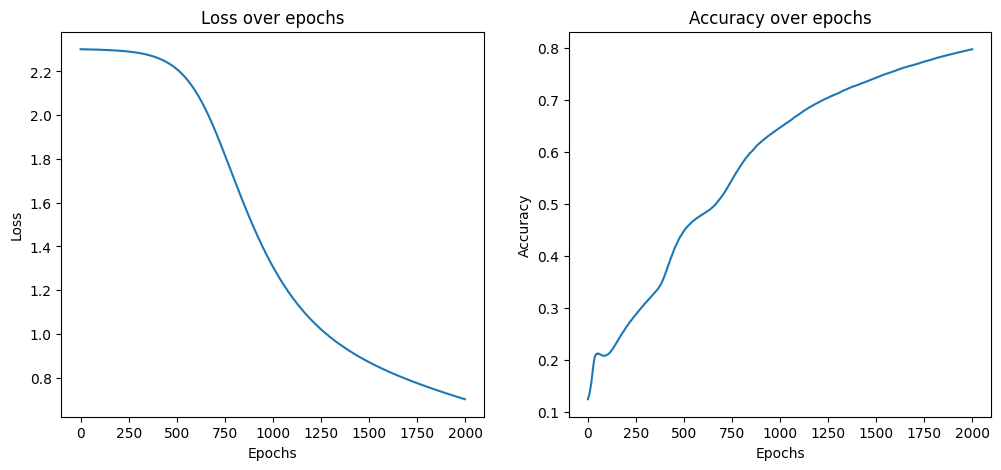

In [15]:
# Plot loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_epochs)
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(accuracy_epochs)
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Save the model
import pickle
with open('./models/nn_model_full_batch.pkl', 'wb') as f:
    pickle.dump(nn, f)

In [17]:
# Test individual training samples and plot the image
def test_sample(sample_index):
    plt.figure(figsize=(2, 2))
    plt.imshow(X_test[sample_index].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.show()
    
    # Predict the label
    y_pred = nn.predict(X_test[sample_index].reshape(1, -1).T)
    print(f"Predicted label: {y_pred[0]}")
    

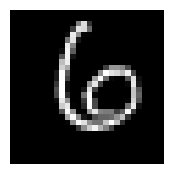

Predicted label: 6


In [18]:
test_sample(100)

In [19]:
# find the samples where it predicted incorrectly
incorrect_indices = np.where(y_pred != y_test)[0]
print(f"Number of incorrect predictions: {len(incorrect_indices)}")

Number of incorrect predictions: 1936


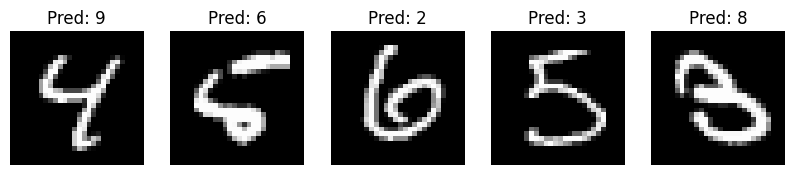

In [20]:
plt.figure(figsize=(10, 2))
for idx, i in enumerate(incorrect_indices[:5]):
    plt.subplot(1, 5, idx + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    y_pred_label = nn.predict(X_test[i].reshape(1, -1).T)
    plt.title(f"Pred: {y_pred_label[0]}")
plt.show()